In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def str_to_float(number):
    '''
    Cette fonction permet de convertir un string en float
    Ex : '1234,56' -> 1234.56
    '''
    num = number.split(',')
    if len(num)==1 :
        return float(num[0])
    else :
        return (float(num[0]+'.'+num[1]))

str_to_float_v = np.vectorize(str_to_float) # Vectorisation de la fonction str_to_float

In [3]:
def new_name(path,ext):
    '''
    Cette fonction permet de renommer un fichier en changeant son extension
    Ex : 'C:\\Users\\user\\Desktop\\data.csv' -> 'C:\\Users\\user\\Desktop\\data.png'
    '''
    componants = path.split("\\")
    name = componants[-1]
    name2 = name[:-4]
    return (name2 + "." + ext)

In [4]:
def create_data(path):
    '''
    Cette fonction retourne les données d'un fichier csv
    Pour l'instant, elle retire la colonne 2 du fichier csv

    A modifier pour choisir la colonne à retirer donc la sonde
    '''
    data = pd.read_csv(path, index_col="Bal", delimiter=";")
    columns = data.columns
    data_to_plot = columns[2]
    val = str_to_float_v(data[data_to_plot].values)
    x = np.arange(0,len(val))
    return x,data_to_plot,val

In [5]:
def plot_csv(path):
    '''
    Cette fonction permet de tracer les données d'un fichier csv
    '''
    x,data_to_plot,val = create_data(path) # Récupération des données

    plt.figure()
    plt.plot(val)
    plt.xlabel("Balayage")
    plt.ylabel(data_to_plot)
    plt.grid()
    plt.savefig('Plot\\'+new_name(path,'png'))
    plt.show()

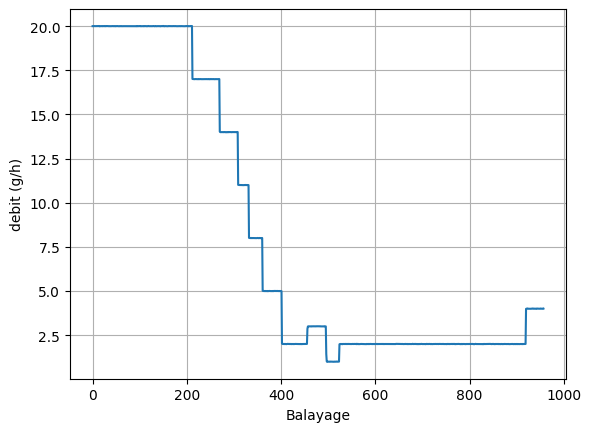

In [6]:
plot_csv("Data\\debit.csv")

In [7]:
def detect_stable_stage(path, precision=0.1, window_size=100, plot=False) :
    '''
    Cette fonction permet de détecter les paliers stables d'un fichier csv
    Elle retourne une matrice de taille (nb_stages,4) avec :
    - La première colonne : le début du palier
    - La deuxième colonne : la fin du palier
    - La troisième colonne : la moyenne du palier
    - La quatrième colonne : la variance du palier

    path : chemin du fichier csv
    precision : seuil de la variance pour détecter un palier
    window_size : taille de la fenêtre de calcul de la variance
    plot : booléen pour afficher le graphe de la variance
    '''
    data = pd.read_csv(path, index_col='Bal', delimiter=';')
    data_of_interest = data.columns[2]
    values = str_to_float_v(data[data_of_interest].values)

    n = len(values)
    variances = np.empty(n-window_size) # tableau des variances
    means = np.empty(n-window_size) # tableau des moyennes
    
    for i in range(n - window_size):
        window_data = values[i:i+window_size] # fenêtre de données
        var = np.var(window_data)
        mean = np.mean(window_data)
        variances[i] = var
        means[i] = mean
        
    points_stage = np.where(variances < precision)[0] 
    points_stage_by_stage = np.split(points_stage, np.where(np.diff(points_stage) != 1)[0]+1) # séparation des paliers
    nb_stages = len(points_stage_by_stage) # nombre de paliers

    stages_matrix = np.empty((nb_stages,4)) # matrice des paliers
    stages_matrix[:,0] = list(map(min,points_stage_by_stage))
    stages_matrix[:,1] = list(map(max,points_stage_by_stage))
    stages_matrix[:,2] = means[stages_matrix[:,0].astype(int)]
    stages_matrix[:,3] = variances[stages_matrix[:,0].astype(int)]

    if plot :
        plt.plot(variances)
        plt.plot([precision]*(n-window_size),'r')
    return stages_matrix

array([[0.000000e+00, 2.020000e+02, 1.999990e+01, 9.290000e-06],
       [2.120000e+02, 2.600000e+02, 1.700230e+01, 1.321000e-05],
       [2.700000e+02, 2.990000e+02, 1.400070e+01, 4.721000e-05],
       [3.090000e+02, 3.220000e+02, 1.100450e+01, 2.065000e-05],
       [3.320000e+02, 3.510000e+02, 8.001600e+00, 1.804000e-05],
       [3.610000e+02, 3.920000e+02, 5.002400e+00, 2.804000e-05],
       [4.020000e+02, 4.460000e+02, 2.003500e+00, 8.265000e-05],
       [4.560000e+02, 4.860000e+02, 2.985100e+00, 1.835090e-03],
       [4.960000e+02, 5.140000e+02, 1.044100e+00, 1.678009e-02],
       [5.240000e+02, 9.100000e+02, 1.997500e+00, 4.425000e-05],
       [9.200000e+02, 9.470000e+02, 3.999700e+00, 4.421000e-05]])

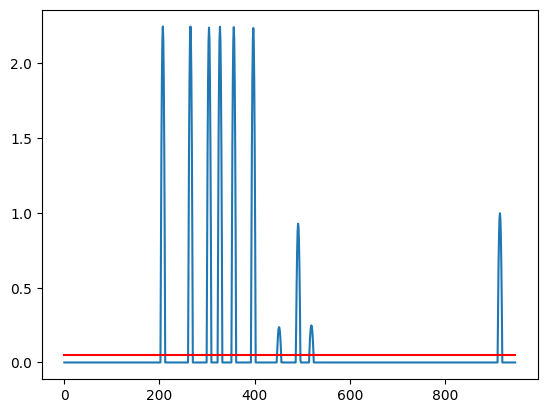

In [21]:
detect_stable_stage("Data\debit.csv",precision=0.05,window_size=10,plot=True)

In [9]:
def stables_stage_csv(path, precision=0.1, window_size=100):
    '''
    Cette fonction permet de détecter les paliers stables d'un fichier csv
    Elle retourne une dataframe de taille (nb_stages,4) avec :
    - La première colonne : le début du palier
    - La deuxième colonne : la fin du palier
    - La troisième colonne : la moyenne du palier
    - La quatrième colonne : la variance du palier
    '''
    stages_matrix = detect_stable_stage(path, precision, window_size)
    nb_stages = len(stages_matrix)
    ind = np.arange(nb_stages)
    df = pd.DataFrame(stages_matrix, index=ind, columns=['Debut','Fin','Moyenne','Variance'])
    df.to_csv('Plot\\mat_'+new_name(path,'csv'))
    return df

In [23]:
stables_stage_csv("Data\debit.csv",precision=0.05,window_size=10)

,Debut,Fin,Moyenne,Variance
0,0.0,202.0,19.9999,0.000009
1,212.0,260.0,17.0023,0.000013
2,270.0,299.0,14.0007,0.000047
3,309.0,322.0,11.0045,0.000021
4,332.0,351.0,8.0016,0.000018
5,361.0,392.0,5.0024,0.000028
6,402.0,446.0,2.0035,0.000083
7,456.0,486.0,2.9851,0.001835
8,496.0,514.0,1.0441,0.016780
9,524.0,910.0,1.9975,0.000044


In [11]:
def stables_stage_list(path, precision=0.1, window_size=100):
    '''
    Cette fonction donne les paliers stables d'un fichier csv sous forme de liste
    Elle retourne une liste de taille (nb_stages,2) avec :
    - La première colonne : la durée du palier
    - La deuxième colonne : la moyenne du palier
    '''
    stages_matrix = detect_stable_stage(path, precision, window_size)
    duree = stages_matrix[:,1] - stages_matrix[:,0]
    mean = stages_matrix[:,2]
    return list(zip(duree,mean))

In [24]:
stables_stage_list("Data\debit.csv",precision=0.05,window_size=10)

[(202.0, 19.999900000000004),
 (48.0, 17.002299999999998),
 (29.0, 14.0007),
 (13.0, 11.0045),
 (19.0, 8.0016),
 (31.0, 5.0024),
 (44.0, 2.0035),
 (30.0, 2.9851),
 (18.0, 1.0440999999999998),
 (386.0, 1.9974999999999998),
 (27.0, 3.9997)]

In [13]:
def polynomial_interpolation(x, y, degree):
    '''
    Cette fonction permet de faire une interpolation polynomiale
    Elle retourne le polynome d'interpolation
    '''
    poly = np.polynomial.polynomial.Polynomial.fit(x, y, degree)
    return poly

In [25]:
x,name,y = create_data("Data\debit.csv")
p = polynomial_interpolation(x,y,3)
print(p)
p(2)

4.62682982816884 - 15.98913312720163 x**1 + 10.094181227474229 x**2 +
7.552081722261025 x**3


23.101328397913235

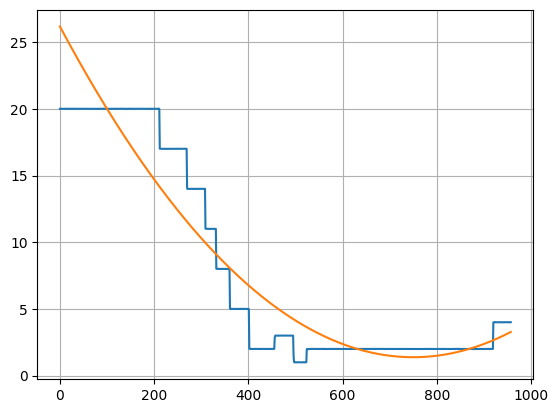

In [30]:
x,name,y = create_data("Data\debit.csv")
plt.figure()
x_corrected = x[0:60000]
y_corrected = y[0:60000]
plt.plot(x_corrected,y_corrected)
p = polynomial_interpolation(x_corrected,y_corrected,2)
z = p(x_corrected)
plt.plot(x_corrected,z)
plt.grid()
plt.show()


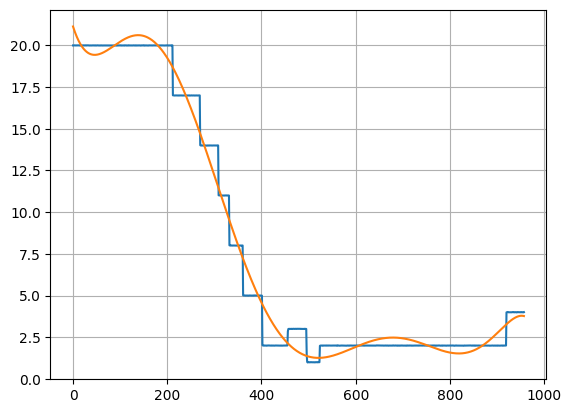

In [16]:
x,name,y = create_data("Data\debit.csv")
plt.figure()
plt.plot(x,y)
p = polynomial_interpolation(x,y,8)
z = p(x)
plt.plot(x,z)
plt.grid()
plt.show()

In [31]:
def linear_interpolation(x, y):
    """Interpolate a linear function through the given points.
    """
    coeffs = np.polyfit(x, y, 1)
    return np.poly1d(coeffs)